In [48]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

In [45]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
#    import sobol_seq
import os
# from sklearn.preprocessing import MinMaxScaler

In [30]:
np.random.seed(1234)

data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
t = np.real(data['t'].flatten()[:,None])
scaler_t = MinMaxScaler()
t = scaler_t.fit_transform(t)
x = np.real(data['x'].flatten()[:,None])
scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)
Exact = np.real(data['usol'])

T, X = np.meshgrid(t,x)

X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
u_star = Exact.flatten()[:,None]


np.random.seed(2025)
triplets_fine = np.hstack([X_star,u_star])
N_all = 800
idx_all = np.random.choice(triplets_fine.shape[0], N_all, replace=False)
triplets_all = triplets_fine[idx_all,:]

# Collocation point set
tx_all = triplets_all[:,:2]


N_obs = 100
idx_obs = np.random.choice(triplets_all.shape[0], N_obs, replace=False)
triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
# Data point set
tx_obs = triplets_obs[:,:2]
u_obs = triplets_obs[:,-1]

In [ ]:
# True contour on fine grid
plt.tricontourf(*triplets_fine[:,:2].T,triplets_fine[:,-1],200)
# Collocation point set
plt.scatter(*tx_all.T,marker='.', s=10, color = 'gray',label = 'collocation point')
# Data point set
plt.scatter(*tx_obs.T, marker = 'x', s=30, color = 'red', alpha=0.3,label = 'data point')


plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.legend(loc = 'upper right')
plt.show()

In [37]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial


u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
# k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,2.])))

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)    
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 10
)

[0.34661498 0.07031898]


In [ ]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

In [39]:
u_sol = p_adjusted[:u_model.num_params]

In [ ]:
# Using obs build the following functions
X = tx_obs
values = u_obs

u_operators = (eval_k,)
feature_operators = (eval_k,dt_k,dx_k,dxx_k)

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

# print(1/(jnp.sqrt(ML_lengthscales)))

u_model = CholInducedRKHS(
    tx_obs,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params = u_model.get_fitted_params(tx_obs,u_obs)

S = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params))
    .reshape(
            len(tx_all), 
            len(feature_operators),
            order = 'F'
        )
)

U_t = S[:,1]
UU_x = jnp.multiply(S[:,0],S[:,2])
U_xx = S[:,3]

Theta = jnp.vstack([UU_x, U_xx]).T

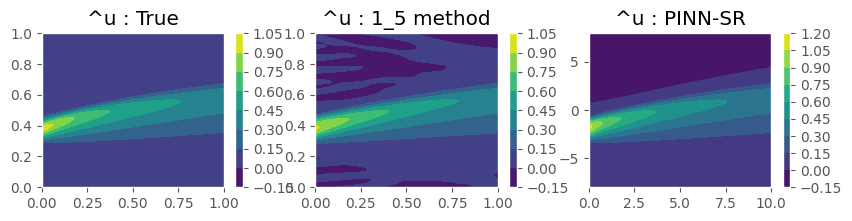

In [48]:
plt.figure(1,figsize=(10,2))
plt.subplot(131)
plt.title('^u : True')
plt.tricontourf(*X_star.T,u_star.flatten())
plt.colorbar()
plt.subplot(132)
plt.title('^u : 1_5 method')
plt.tricontourf(*X_star.T,u_pred.flatten())
plt.colorbar()
plt.subplot(133)
plt.title('^u : PINN-SR')
data_pinnsr = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/Pred.mat')
u_pred_pinnsr = data_pinnsr['u_FullField_Pred']
data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
t = np.real(data['t'].flatten()[:,None])
x = np.real(data['x'].flatten()[:,None])
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star2 = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star2[:,[1,0]] = X_star2[:,[0,1]]
u_star2 = Exact.flatten()[:,None] 
plt.tricontourf(*X_star2.T,u_pred_pinnsr.flatten())
plt.colorbar()
plt.show()

In [52]:
from evaluation_metrics import get_nrmse
true = u_star.flatten()
true_flipped = u_star2.flatten()
u_error_1_5 = get_nrmse(true,u_pred)
u_error_pinn = get_nrmse(true_flipped,u_pred_pinnsr.flatten())
print('Error 1_5 step method: ', u_error_1_5)
print('Error PINN method: ', u_error_pinn)

Error 1_5 step method:  0.07045521017059002
Error PINN method:  0.051997983805839754


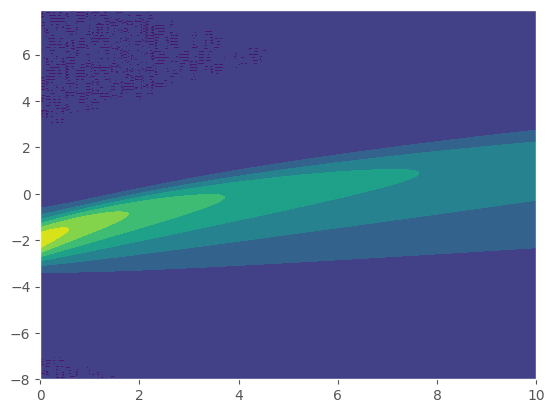

In [59]:
plt.tricontourf(*X_star2.T, u_star2.flatten())

In [49]:
def get_error_1_5(n_obs, n_coll, run):
    # Generate data

    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # Scale t
    scaler_t = MinMaxScaler()
    t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # Scale x
    scaler_x = MinMaxScaler()
    x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]
    print(tx_all.shape)


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(run), a = triplets_all, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    # Run 1_5 step method

    u_operators = (eval_k,)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    
    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
        .reshape(
                len(tx_all),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)    
        
    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_all,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 10
    )

    # Optimize - LM
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    params,convergence_data = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        max_iter = 501,
        init_alpha=0.1,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
    # u_params
    u_sol = p_adjusted[:u_model.num_params]
    # u_true 
    u_true = u_star.flatten()
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))
    
    return error_u_field

In [52]:
res = get_error_1_5(100,900,1)

(900, 2)
[0.17829865 0.1103618 ]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.2261, Jres = 192.9, alpha = 0.08333, improvement_ratio = 0.9106
Iteration 1, loss = 0.1094, Jres = 18.71, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.06627, Jres = 13.18, alpha = 0.05787, improvement_ratio = 1.041
Iteration 3, loss = 0.04381, Jres = 2.676, alpha = 0.04823, improvement_ratio = 0.9967
Iteration 4, loss = 0.03094, Jres = 2.658, alpha = 0.04019, improvement_ratio = 0.985
Iteration 5, loss = 0.02305, Jres = 1.751, alpha = 0.03349, improvement_ratio = 0.9787
Iteration 100, loss = 0.0004474, Jres = 0.293, alpha = 8.333e-07, improvement_ratio = 0.9839
Iteration 200, loss = 0.0003904, Jres = 0.08409, alpha = 8.333e-07, improvement_ratio = 0.9915
Iteration 300, loss = 0.000375, Jres = 0.002871, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.0003666, Jres = 0.007746, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 500, loss = 0.0003603, Jres = 0.007804, alpha = 8.333e-07, improvement_ratio = 0.9997


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.00036013307358552505
Iteration 190 Step Failed
Iteration 248 Step Failed
Iteration 250 Step Failed
Iteration 251 Step Failed
Iteration 252 Step Failed
Iteration 254 Step Failed
Iteration 255 Step Failed


In [53]:
res

Array(0.0735728, dtype=float64)